In [1]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift

In [2]:
def simulate_diffusion(simsize, bmax, bigDelta, smallDelta, gmax, gamma, FA, Dxx_base, fiber_fractions, angle_xy, angle_yz):
    qmax = gamma / (2 * np.pi) * smallDelta * gmax
    qDelta = qmax * 2 / (simsize - 1)
    rFOV = 1 / qDelta
    rmax = rFOV / 2

    # Create grid for R-space
    grid = np.linspace(-rmax, rmax, simsize)
    X, Y, Z = np.meshgrid(grid, grid, grid, indexing='ij')

    # Coefficients for R-space normalization
    pi_coeff = (4 * np.pi * bigDelta) ** 3

    # Diffusion simulation
    rspace_total = np.zeros_like(X)
    for fraction, angle_xy, angle_yz, Dxx in zip(fiber_fractions, angle_xy, angle_yz, Dxx_base):
        # Calculate fiber rotation around x-y plane:
        angle = np.radians(angle_xy)
        cos_angle, sin_angle = np.cos(angle), np.sin(angle)
        Xr = X * cos_angle + Y * sin_angle
        Yr = Y * cos_angle - X * sin_angle

        # Calculate fiber rotation around y-z plane:
        angle = np.radians(angle_yz)
        cos_angle, sin_angle = np.cos(angle), np.sin(angle)
        Yr = Yr * cos_angle + Z * sin_angle
        Zr = Z * cos_angle - Yr * sin_angle

        # Diffusion coefficients, updated to vary per fiber
        Dyy = Dxx * (1 - FA) / np.sqrt(16)
        Dzz = Dxx * (1 - FA) / np.sqrt(16)

        # R-space distribution for the current fiber
        rspace = 1 / np.sqrt(pi_coeff * Dxx * Dyy * Dzz) * np.exp(
            -(Xr ** 2 / (4 * Dxx * bigDelta) + Yr ** 2 / (4 * Dyy * bigDelta) + Z ** 2 / (4 * Dzz * bigDelta)))
        rspace_total += fraction * rspace

    # Fourier transform to Q-space (Signal)
    qspace = fftshift(fftn(ifftshift(rspace_total)))

    # Work with the magnitude of the qspace, disregard the phase information
    qspace = np.abs(qspace)

    return rspace_total, qspace

In [3]:
# Parameters
n_samples = 5  # Number of different samples to generate
simsize = 33
bmax = 10000  # s/mm^2
bigDelta = 66e-3  # sec
smallDelta = 60e-3  # sec
gmax = 40e-3  # T/m
gamma = 2 * np.pi * 42.57e6  # Hz/T for proton
Dxx_individual = np.array([2e-9])  # m^2/s
FA = 0.2  # Fractional anisotropy
fiber_fractions = np.array([0.01, 0.99])
angle_xy = np.array([90., 0.])
angle_yz = np.array([0., 90.])

save_dir = 'data'

In [4]:
rspace, qspace = simulate_diffusion(simsize, bmax, bigDelta, smallDelta, gmax, gamma, FA, Dxx_individual, fiber_fractions, angle_xy, angle_yz)

In [5]:
print(rspace.shape)
print(qspace.shape)

(33, 33, 33)
(33, 33, 33)


2.4820540081066325e-44
740106658602.7137
Number of zeros in r-space data: 0
Number of infinities in r-space data: 0
Number of NaNs in r-space data: 0
(33, 33, 33)


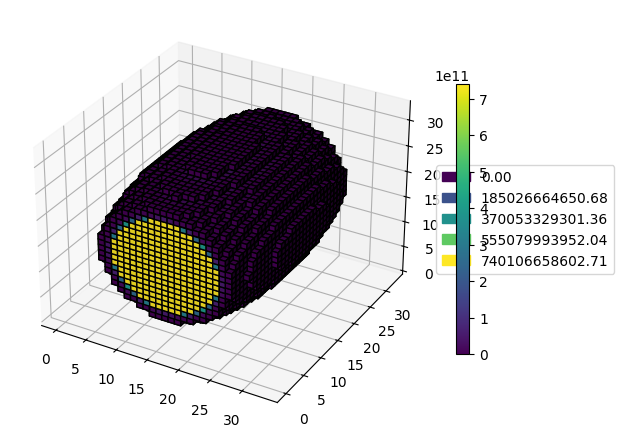

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

print(np.min(rspace))
print(np.max(rspace))
up_th = 26166721854964.797
low_th = 3.5030014994588684e-4

# Create np array where values between the thresholds are set to 1
fill = np.where((rspace > low_th) & (rspace < up_th), 1, 0)


# Count number of zeros in the r-space data
print(f'Number of zeros in r-space data: {np.sum(rspace == 0)}')
print(f'Number of infinities in r-space data: {np.sum(np.isinf(rspace))}')
print(f'Number of NaNs in r-space data: {np.sum(np.isnan(rspace))}')
print(rspace.shape)

# Plot the r-space data
norm = Normalize(vmin=rspace.min(), vmax=rspace.max())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(filled=fill, facecolors=plt.cm.viridis(rspace), edgecolors='k')

# Create a colorbar with the viridis colormap
mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
mappable.set_array([])
plt.colorbar(mappable, ax=ax, shrink=0.6)

# Create legend patches
legend_patches = [Patch(color=plt.cm.viridis(norm(value)), label=f'{value:.2f}') for value in np.linspace(rspace.min(), rspace.max(), num=5)]
# Add legend to plot
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
